# About Dataset

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews 



The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

* Number of reviews: 568,454
* Number of users: 256,059
* Number of products: 74,258
* Timespan: Oct 1999 - Oct 2012
* Number of Attributes/Columns in data: 10

### Attribute Information:

* Id
* ProductId - unique identifier for the product
* UserId - unqiue identifier for the user
* ProfileName
* HelpfulnessNumerator - number of users who found the review helpful
* HelpfulnessDenominator - number of users who indicated whether they found the * review helpful or not
* Score - rating between 1 and 5
* Time - timestamp for the review
* Summary - brief summary of the review
* Text - text of the review


### Objective:

**Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).**


> How to determine if a review is positive or negative?

We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# [1] Reading data

In [27]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from bs4 import BeautifulSoup
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import seaborn as sns
from tqdm import tqdm
import os

We have data in format of sql. So we will use sqlite to read it

In [28]:
#mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
os.chdir('gdrive/My Drive/Amazon_fine_food')

We have data available in sqlite format.We will read those datapoints in which rating is not equal to 3.We feed so that we can take those datapoints where rating above 3 can be considered as positive review and rating below 3 can be considerd as negative reviews.

In [ ]:
# using SQLite Table to read data.
con = sqlite3.connect('data/database.sqlite') 
data = pd.read_sql_query(""" SELECT * FROM Reviews""", con)

print(f'Shape of data is {data.shape}')

data.head()

Shape of data is (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# [2] Exploratory data Analysis

##Data cleaning

**First we will check for missing values**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568454 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568454 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


We can see that we don't have any null values. 

**Now we will check for duplicate entries**

In [ ]:
# filtered_data = data.drop(columns=['ProductId'])
dup = data[data.duplicated(subset=['UserId','ProfileName','Time','Text'],keep=False)]
dup.shape

(232415, 10)

In [ ]:
# example for duplicate entry
# 'AR5J8UI46CURR'
dup[dup['UserId'] == 'A395BORC6FGVXV']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
136303,136304,B002Y7526Y,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
544172,544173,B000U9WZ54,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...


Now we will keep only the first entry and will delete rest of the entry

In [ ]:
df = data.drop_duplicates(subset=['UserId','ProfileName','Time','Text'],keep='first',inplace=False)
df.shape

(393933, 10)

Our data points gets reduced to approx 69%

In [ ]:
#Checking to see how much % of data still remains
print(f'Remaining data is {((df.shape[0]*1.0)/(data.shape[0]*1.0))*100}')

Remaining data is 69.29901100176971


In [ ]:
df.shape

(393933, 10)

# Analyisis of Reviews over time

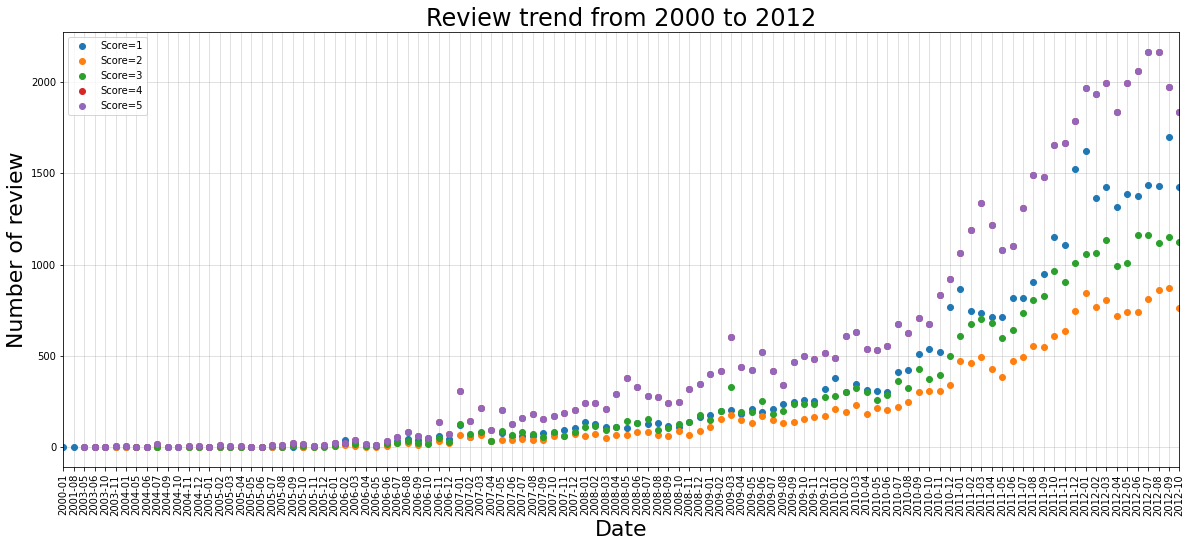

In [ ]:
df['date'] = pd.to_datetime(df['Time'],unit='s')
dff = df[['date','Text','Score']]
dff.date = df.date.dt.strftime('%Y-%m')
# dff['date'] = dff['date'].dt.to_timestamp()
dff = dff.sort_values(by=['date']).reset_index(drop=True)
dff_1 = dff[dff['Score'] == 1]
dff_2 = dff[dff['Score'] == 2]
dff_3 = dff[dff['Score'] == 3]
dff_4 = dff[dff['Score'] == 4]
dff_5 = dff[dff['Score'] == 5]

dff_1 = dff_1.groupby('date')['Score'].count().reset_index()
dff_2 = dff_2.groupby('date')['Score'].count().reset_index()
dff_3 = dff_3.groupby('date')['Score'].count().reset_index()
dff_5 = dff_4.groupby('date')['Score'].count().reset_index()
dff_4 = dff_4.groupby('date')['Score'].count().reset_index()

plt.figure(figsize=(20,8))

plt.plot_date(x=dff_1['date'],y=dff_1['Score'],label='Score=1')
plt.plot_date(x=dff_2['date'],y=dff_2['Score'],label='Score=2')
plt.plot_date(x=dff_3['date'],y=dff_3['Score'],label='Score=3')
plt.plot_date(x=dff_4['date'],y=dff_4['Score'],label='Score=4')
plt.plot_date(x=dff_5['date'],y=dff_5['Score'],label='Score=5')
plt.grid(linewidth=0.5,alpha=0.75)
plt.xticks(rotation=90)
plt.xlim('2000-01','2012-10')
plt.xlabel('Date',fontsize=22)
plt.ylabel('Number of review',fontsize=22)
plt.title('Review trend from 2000 to 2012',fontsize=24);
plt.savefig('review_trend.png')
plt.legend()
plt.show()

# Analysis on Score (Target Variable)

Now we will create our target variable from review stars. Before that we will filter only those reviews with rating > 3(positive) and less than 3(negative)

In [ ]:
df = df[df['Score'] != 3]
df.shape 
#Checking to see how much % of data still remains
print(f'Remaining data is {((df.shape[0]*1.0)/(data.shape[0]*1.0))*100}')

Remaining data is 64.06217565537405


In [ ]:

score = df['Score'].apply(lambda x: 1 if x > 3 else 0)
df['Score'] = score
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18


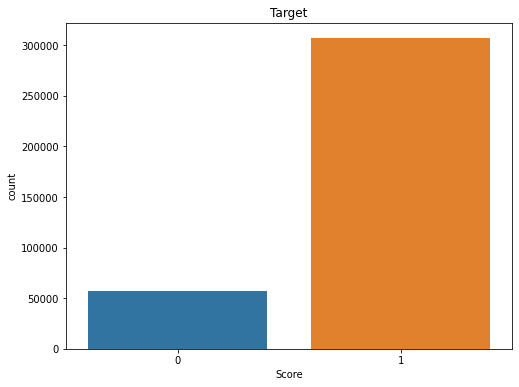

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(df['Score'])
plt.title('Target')
plt.show()

**Observation:** It is clear that we have an imbalenced dataset for classification. So We cannot choose accuracy as a metric. So here we will go with AUC(Area under ROC curve)

> Why accuracy not for imbalanced datasets? <br>

Consider a scenario like this where we have imbalenced dataset. For example consider case of credit card fraud detection with 98% percentage of points as non-fraud(1) and rest 2% points as fraud(1). In such cases even if we predict all the points as non-fraud also we will get 98% accuracy. But actually it is not the case. So we can't use accuracy as a metric. <br>

> What is AUC ROC?

AUC is the area under ROC curve.It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.


## Analysis On ProductId and UserId

In [ ]:
# we will see the products brought by each customer

purchases = df[['ProductId','UserId']].groupby('UserId').agg({'ProductId': ['count']})
purchases.columns = ['No_of_products_purchased']
purchases = purchases.reset_index()
purchases.head(2)

,UserId,No_of_products_purchased
0,#oc-R103C0QSV1DF5E,1
1,#oc-R109MU5OBBZ59U,1


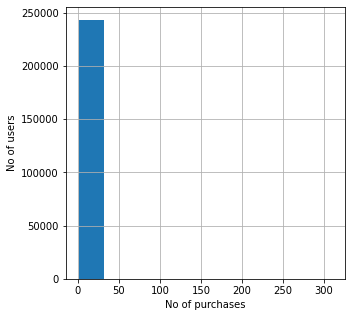

count    243412.000000
mean          1.496081
std           2.537677
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         310.000000
Name: No_of_products_purchased, dtype: float64


In [ ]:
plt.figure(figsize=(5,5))
purchases['No_of_products_purchased'].hist()
plt.xlabel('No of purchases')
plt.ylabel('No of users')
plt.show()
print(purchases['No_of_products_purchased'].describe())

We can see that majority of the users purchased only 1 product. Maximum number of product purchased by a single user is 310

## Analysis on HelpfulnessNumerator and HelpfulnessDenominator

* Helpfulness Numerator: Number of users who found the review helpful
* Helpfulness Denominator: Number of users who indicated whether they found the review helpful or not


In [ ]:
df[df['HelpfulnessNumerator'] > df['HelpfulnessDenominator']]


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...,2008-06-08
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...,2008-10-25


It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
df = df[df['HelpfulnessNumerator'] <= df['HelpfulnessDenominator']]
df.shape

(364162, 11)

In [ ]:
#Checking to see how much % of data still remains
print(f'Remaining data is {((df.shape[0]*1.0)/(data.shape[0]*1.0))*100}')

Remaining data is 64.06182382391539


## Preprocessing Text data

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-



1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
<!-- 7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming) -->






In [ ]:
# df['text'] = df['Summary'] + df['Text']
df['text'] = df['Text']

In [ ]:
# replacing some phrases like won't with will not

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])



preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(df['text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    # removing html tags
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    # removing extra spaces and numbers
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    # removing non alphabels
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())


100%|██████████| 364162/364162 [02:39<00:00, 2288.48it/s]


In [ ]:
#combining required columns
df['clean_text'] = preprocessed_reviews
df = df[['Time','clean_text','Score']]
#reseting index
df = df.reset_index(drop=True)
#saving processed file
df.to_csv('processed_df.csv',index=False)

Reading Processed file

In [ ]:
df = pd.read_csv('processed_df.csv')
print(df.shape)
df.head()

(364162, 3)


,Time,clean_text,Score
0,1303862400,bought several vitality canned dog food produc...,1
1,1346976000,product arrived labeled jumbo salted peanuts p...,0
2,1219017600,confection around centuries light pillowy citr...,1
3,1307923200,looking secret ingredient robitussin believe f...,0
4,1350777600,great taffy great price wide assortment yummy ...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364162 entries, 0 to 364161
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Time        364162 non-null  int64 
 1   clean_text  363184 non-null  object
 2   Score       364162 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.3+ MB


In [ ]:
#one row is empty.we will drop it
df = df.dropna(axis=0)
df.shape

(363184, 3)

 We are considering time beacuse our reviews are developed over time.So splitting based on that makes more sense

In [ ]:
#sampling 100k points 
df = df.sample(100000,random_state=100)

In [ ]:
#sortimg based on time
df['Time'] = pd.to_datetime(df['Time'],unit='s')
df = df.sort_values('Time')
df = df.reset_index(drop=True)

Now we will split the data to train,cv and test

In [ ]:
#splitting data to train.cv and test
from sklearn.model_selection import train_test_split
x = df['clean_text']
y = df['Score']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=100)
# X_tr,X_cv,y_tr,y_cv = train_test_split(X_train,y_train,test_size=0.3,stratify=y_train,random_state=100)
print(f'shape of X_train is {X_train.shape}')
print(f'shape of X_test is {X_test.shape}')
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train is (70000,)
shape of X_test is (30000,)
shape of y_train is (70000,)
shape of y_test is (30000,)


In [ ]:
np.save('saved_feats/X_train', X_train)
np.save('saved_feats/y_train', y_train)
np.save('saved_feats/X_test', X_test)
np.save('saved_feats/y_test', y_test)


# Bag of Words

In [ ]:
bow = CountVectorizer()
bow.fit(X_train)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)
bow_features = bow.get_feature_names()

print('shape of X_train_bow is {}'.format(X_train_bow.get_shape()))
print('shape of X_test_bow is {}'.format(X_test_bow.get_shape()))

shape of X_train_bow is (70000, 51038)
shape of X_test_bow is (30000, 51038)


In [ ]:
#saving bow vectors
import pickle
pickle.dump(X_train_bow, open("saved_feats/X_train_bow","wb"))
pickle.dump(X_test_bow, open("saved_feats/X_test_bow","wb"))
pickle.dump(np.array(bow_features), open("saved_feats/bow_features","wb"))

# Tfidf

In [ ]:
#applying bow on x_train and x_test
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
tfidf_features = vectorizer.get_feature_names()
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
#saving tfidf vectors
pickle.dump(X_train_tfidf, open("saved_feats/X_train_tfidf","wb"))
pickle.dump(X_test_tfidf, open("saved_feats/X_test_tfidf","wb"))
pickle.dump(np.array(tfidf_features), open("saved_feats/tfidf_features","wb"))

# Word2vec



In [ ]:
preprocessed_reviews = X_train.values
train_sentence = [rev.split() for rev in preprocessed_reviews]
# min_count = 5 considers only words that occured atleast 5 times
# size = length of vector
w2v_model_train = Word2Vec(train_sentence,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model_train.wv.vocab)


In [ ]:
pickle.dump(np.array(w2v_words),open("saved_feats/w2v_words","wb"))

# Average Word2vec

In [ ]:
train_reviews = X_train.values
train_sentence = [rev.split() for rev in train_reviews]

sent_vectors_train = []
for sent in tqdm(train_sentence):
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        if word in w2v_words:
            vector = w2v_model_train.wv[word]
            sent_vec += vector
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

########################################################
test_reviews = X_test.values
test_sentence = [rev.split() for rev in test_reviews]

sent_vectors_test = []
for sent in tqdm(test_sentence):
    count = 0
    sent_vec = np.zeros(50)
    for word in sent:
        if word in w2v_words:
            vector = w2v_model_train.wv[word]
            sent_vec += vector
            count += 1
            
    if count != 0:
        sent_vec /= count
    sent_vectors_test.append(sent_vec)

print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

  0%|          | 51/30000 [00:00<00:58, 509.67it/s]

70000
50


100%|██████████| 30000/30000 [00:54<00:00, 555.37it/s]

30000
50


In [ ]:
X_train_avgw2v = np.array(sent_vectors_train)
X_test_avgw2v = np.array(sent_vectors_test)

pickle.dump(np.array(X_train_avgw2v), open("saved_feats/X_train_avgw2v","wb"))
pickle.dump(np.array(X_test_avgw2v), open("saved_feats/X_test_avgw2v","wb"))



# Tfidf Word2Vec

In [ ]:


w2v_words = pickle.load(open("saved_feats/w2v_words","rb")).tolist()
tfidf = TfidfVectorizer()
tfidf.fit(X_train)
dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feats = tfidf.get_feature_names()

#saving
pickle.dump(tfidf_feats, open("saved_feats/tfidf_feats_w2v","wb"))


In [ ]:
train_reviews = X_train.values
train_sentence = [rev.split() for rev in train_reviews]
sent_vectors_train = []
for sent in tqdm(train_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in tfidf_feats and word in w2v_words:
            vec = w2v_model_train.wv[word]
            # tf * idf
            tfidf_value = (sent.count(word)/len(sent)) * dictionary[word] 
            vec = vec * tfidf_value
            sent_vec += vec
            weight_sum += tfidf_value
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(sent_vectors_train[0])
X_train_tfw2v = sent_vectors_train

pickle.dump(np.array(X_train_tfw2v), open("saved_feats/X_train_tfw2v","wb"))

100%|██████████| 70000/70000 [26:22<00:00, 44.23it/s]


70000
[ 0.58852566 -0.14504878 -0.08189659 -0.55538212 -0.10965156  0.57289314
 -0.6463609  -1.57068631  0.17610996 -0.54203487  1.30474104 -0.56435649
  1.15296988  1.69737555  0.83967908  1.82923313 -0.70703604  0.13471628
  0.08083214 -0.77296371 -1.21259213 -1.07761326  0.21765423 -0.33065811
  0.08837798  0.32674941  0.33328268 -0.13033061  0.21215169  1.28758244
 -0.32904252  0.12981891 -0.73704851  1.04464942  0.61967336  0.58958777
  0.9508683   0.04209961 -0.05918515  0.16966771  1.03845286 -0.68942989
 -1.11771285  1.0964333   1.26746402  1.0538764  -0.1432131   0.111346
  0.49083798  0.12901925]


In [ ]:
test_reviews = X_test.values
test_sentence = [rev.split() for rev in test_reviews]
sent_vectors_test = []
for sent in tqdm(test_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in tfidf_feats and word in w2v_words:
            vec = w2v_model_train.wv[word]
            # tf * idf
            tfidf_value = (sent.count(word)/len(sent)) * dictionary[word] 
            vec = vec * tfidf_value
            sent_vec += vec
            weight_sum += tfidf_value
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(sent_vectors_test[0])   

100%|██████████| 30000/30000 [11:03<00:00, 45.19it/s]

30000
[-0.40509951 -0.37584518 -0.21359617  0.71815309  0.37926    -0.55179429
 -0.14220705 -0.26483384 -0.02341689  0.01964453  0.28598622  0.2898339
 -0.51936596  0.33237323 -0.29203323 -0.25422458 -0.32015789  0.19741509
  0.78614736  0.76298628 -1.10877806 -0.3108676  -0.44545325 -0.21573851
 -0.43798279 -0.10679173  0.28487073  0.23236588  0.90289826 -0.21048079
 -0.03001833  0.15388801  0.17239111 -0.66590301  0.10477625  0.43725751
  0.65841573 -0.24782139 -0.22928751  0.31861714 -0.2151029  -0.75319591
 -0.31587245  0.61634559 -0.50134069 -0.10601186 -0.0365299  -0.11926447
  0.88762651  0.17191809]


In [ ]:

X_test_tfw2v = sent_vectors_test

pickle.dump(np.array(X_test_tfw2v), open("saved_feats/X_test_tfw2v","wb"))

## Loading saved vectors

In [30]:
# loading bow vectors
X_train_bow = pickle.load(open("saved_feats/X_train_bow","rb"))
X_test_bow = pickle.load(open("saved_feats/X_test_bow","rb"))
bow_features = pickle.load(open("saved_feats/bow_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_bow.shape))
print('shape of X_test_bow is {}'.format(X_test_bow.shape))


#loading tfidf vectors
X_train_tfidf = pickle.load(open("saved_feats/X_train_tfidf","rb"))
X_test_tfidf = pickle.load(open("saved_feats/X_test_tfidf","rb"))
tfidf_features = pickle.load(open("saved_feats/tfidf_features","rb")).tolist()
print('shape of X_train_tfidf is {}'.format(X_train_tfidf.shape))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.shape))


w2v_words = pickle.load(open("saved_feats/w2v_words","rb")).tolist()
#avgw2v
X_train_avgw2v = pickle.load(open("saved_feats/X_train_avgw2v","rb"))
X_test_avgw2v = pickle.load(open("saved_feats/X_test_avgw2v","rb"))
print('shape of X_train_avgw2v is {}'.format(X_train_avgw2v.shape))
print('shape of X_test_avgw2v is {}'.format(X_test_avgw2v.shape))


#tfidf-w2v
X_train_tfw2v = pickle.load(open("saved_feats/X_train_tfw2v","rb"))
X_test_tfw2v = pickle.load(open("saved_feats/X_test_tfw2v","rb"))
print('shape of X_train_tfw2v is {}'.format(X_train_tfw2v.shape))
print('shape of X_test_tfw2v is {}'.format(X_test_tfw2v.shape))


y_train = np.load('saved_feats/y_train.npy',allow_pickle=True)
y_test = np.load('saved_feats/y_test.npy',allow_pickle=True)
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train_bow is (70000, 51038)
shape of X_test_bow is (30000, 51038)
shape of X_train_tfidf is (70000, 51038)
shape of X_test_tfidf is (30000, 51038)
shape of X_train_avgw2v is (70000, 50)
shape of X_test_avgw2v is (30000, 50)
shape of X_train_tfw2v is (70000, 50)
shape of X_test_tfw2v is (30000, 50)
shape of y_train is (70000,)
shape of y_test is (30000,)
